# Basketball Inferential Analysis
<hr>
### Players: 
<ol>
    <li>Shaq</li>
    <li>The Big Fundamental</li>
    <li>The Dream</li>
    <li>Round Mound of Rebound</li>
    <li>The Mail Man</li>
    <li>Kareem</li>
    <li>KG</li>
    <li>The Admiral</li>
</ol>

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import OrderedDict


%matplotlib inline

In [106]:
player_dict = OrderedDict([("shaq_dframe", "https://www.basketball-reference.com/players/o/onealsh01.html"),
                           ("td_dframe", "https://www.basketball-reference.com/players/d/duncati01.html"),
                           ("kg_dframe", "https://www.basketball-reference.com/players/g/garneke01.html"),
                           ("ka_dframe", "https://www.basketball-reference.com/players/a/abdulka01.html"),
                           ("ho_dframe", "https://www.basketball-reference.com/players/o/olajuha01.html"),
                           ("cb_dframe", "https://www.basketball-reference.com/players/b/barklch01.html"),
                           ("km_dframe", "https://www.basketball-reference.com/players/m/malonka01.html"),
                           ("dr_dframe", "https://www.basketball-reference.com/players/r/robinda01.html")
                          ])

 I'm only interested in the seasons averages for:

 <ul>
     <li>assists</li>
     <li>points</li>
     <li>rebounds</li>
 </ul>

 and we'll throw age in their as well, just so we have it

In [107]:
dframes = OrderedDict()
for k, url in player_dict.items():
    dframes[k] = pd.read_html(url)[0][['AST','PTS','TRB','Age']]

In [108]:
dframes['ho_dframe'][:5]

,AST,PTS,TRB,Age
0,1.4,20.6,11.9,22.0
1,2.0,23.5,11.5,23.0
2,2.9,23.4,11.4,24.0
3,2.1,22.8,12.1,25.0
4,1.8,24.8,13.5,26.0


So we know based on the index passed to dframes that these stats belong to the Dream, but there is no way of knowing this by looking at the dframe itself. 


Thus now that we have a dictionary containing the player dframes, let's add an additional column that identifies the player. For this we will use a list containing the player initials that **follows the same order as the player_dict keys**, i.e., `initials[0] = 'SO'`and `list(dframe.keys())[0] = 'shaq_dframe'`.

In [109]:
initials = ['SO', 'TD', 'KG', 'KA', 'HO', 'CB', 'KM', 'DR' ]
dframe_list = list()
i = 0
for k in dframes.keys():
    dframes[k]['player'] = pd.Series([initials[i] for n in range(len(dframes[k]))])
    dframe_list.append(dframes[k])
    i += 1

main_frame = pd.concat(dframe_list)

In [110]:
main_frame.head()

,AST,PTS,TRB,Age,player
0,1.9,23.4,13.9,20.0,SO
1,2.4,29.3,13.2,21.0,SO
2,2.7,29.3,11.4,22.0,SO
3,2.9,26.6,11.0,23.0,SO
4,3.1,26.2,12.5,24.0,SO


In [111]:
main_frame.tail()

,AST,PTS,TRB,Age,player
10,1.8,17.8,9.6,34.0,DR
11,1.5,14.4,8.6,35.0,DR
12,1.2,12.2,8.3,36.0,DR
13,1.0,8.5,7.9,37.0,DR
14,2.5,21.1,10.6,NaN,DR


In [112]:
# Let's take a look at the data
main_frame.describe()

,AST,PTS,TRB,Age
count,158.000000,158.000000,158.000000,150.00000
mean,3.100633,21.145570,10.553797,30.18000
std,1.106063,6.072016,2.415150,5.50664
min,0.700000,3.200000,3.900000,19.00000
25%,2.400000,17.550000,8.925000,26.00000
50%,3.000000,22.200000,10.800000,30.00000
75%,3.900000,25.600000,12.100000,35.00000
max,6.000000,34.800000,16.900000,41.00000


## Let's check the distrubitions and see if there's any funny business

In [113]:
boards = pd.Series(main_frame['TRB'], name="Boards")

In [114]:
points = pd.Series(main_frame['PTS'], name="Points")

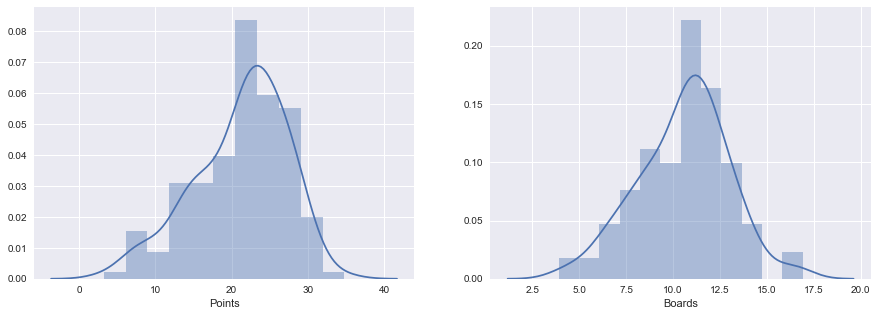

In [115]:
sns.set_style("darkgrid")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
point_dist = sns.distplot(points, label="Points", ax=ax1)
boards_dist = sns.distplot(boards, label="Boards", ax=ax2)

In [116]:
# Compute the means
boardsMean = sum(boards) / float(len(boards))
pointsMean = sum(points) / float(len(points))

print("boards M: ",boardsMean)
print("points M: ",pointsMean)

boards M:  10.5537974684
points M:  21.1455696203


In [117]:
sampleSize = len(points)
numN = sampleSize * (sampleSize+1) * (sampleSize-1)
denN = (sampleSize-2) * (sampleSize-3)
numMoment = 0
denMoment = 0
for i in points:
    numMoment += i**4 - pointsMean**4
    denMoment += (i**2 - pointsMean**2) ** 2

sampleK = numN/denN * numMoment/denMoment 

In [118]:
sampleK

255.53136519986671

There appears to be quite low variance, i.e., leptokurtic, in these samples and a slight skew to the left -- this is likely due to the size of the data set (*n*=158). However, considering this analysis is more for expository purposes and there is a relatively normal distribution for each sample, we'll accept the data in its current form.
<hr>
Next, let's view the shape of the relationship between boards and points, specifically our intention is to regress points onto boards.

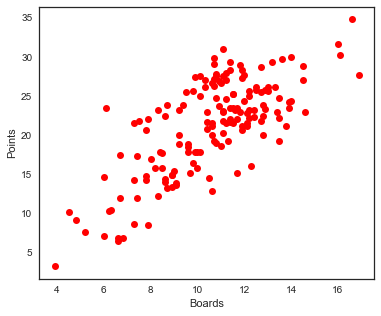

In [119]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(6,5))
ax.plot(boards, points, 'ro')
ax.set_xlabel("Boards")
ax.set_ylabel("Points")

This data has a decent homoscedasticity, though there does appear to be some clustering around the the 20 points, 12 rebounds, and a nice linear trend, thus simple linear regression seems to be the right
tool for the job.

## Simple Linear Regression Analysis
<hr>
For this section we will be trying to use as little dependencies as possible. I recently had an interesting discussion with a  Python expert regarding which learning method is best for programming: 
<ol>
<li>Results first (namely, use of libraries/built-in functions), the fundamentals will come</li>
<li>Super-strong understanding of the fundamentals, then implement libraries</li>
</ol>

Though he is the Python expert, I have an undergraduate in psychology, thus I will be going with the latter method.

### Formulas
All the formulas I am using are present in *An Introduction to Statistical Learning with Applications in R,* by James et al., 2013.

*Note: At the end of this notebook we'll compare the accuracy of my code to Scipy's*
<br>

First, let's get everthing we needs to compute our slope. 
We will be modelling the following equation (p.62): 
<br>
<br>
$\huge\hat\beta_1=\frac{\sum_{i=0}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=0}^n(x_i - \bar{x})^2}$
<br>
Recall that $x_n$ and $y_n$ represent our rebounds and points, respectively.

In [120]:
# Calculate the slope
rise = 0
run = 0
for i, x in enumerate(list(boards)):
    rise += (x - boardsMean) * (list(points)[i] - pointsMean) 
    run += (x - boardsMean) ** 2

mySlope = rise/run
mySlope

1.8520781612871864

Now that we have our slope let's get our intercept (p.62).
<br>
<br>
$\huge\hat\beta_0=\bar{y}-\hat\beta_1\bar{x}$

In [121]:
yInter = pointsMean - (mySlope * boardsMean) 
yInter

1.5991118104659208

Let's view our regression line and see how well our coefficients fit the data.

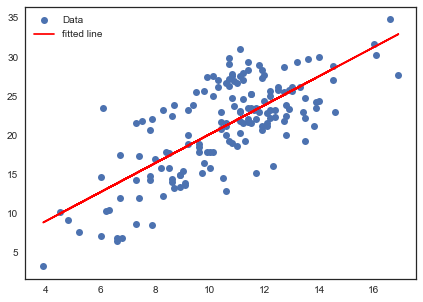

In [122]:
f, ax = plt.subplots(figsize=(7,5))
sns.set_style("white")
scatter = ax.plot(boards, points, 'o', label='Data')
line = ax.plot(boards, yInter + mySlope*boards, 'r', label='fitted line')
plt.legend()

Looks pretty good to me, but it doesn't look pretty. Let's see how the seaborn ```regplot()``` function matches up with my graph.

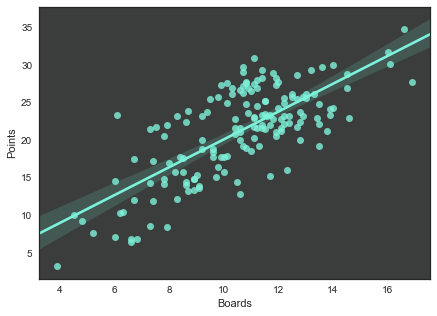

In [123]:
f, ax = plt.subplots(figsize = (7,5))
ax.set_facecolor('#3a3d3c')
ax = sns.regplot(x=boards, y=points, color="#7df2da")

$\huge\textit{RSS} = (y_n - \beta_0 - \beta_n x_n)$

In [124]:
# Compute the residual sum of squares
RSS = 0
for i, y in enumerate(list(points)):
    RSS += (y - (yInter + (mySlope*list(boards)[i])))**2
RSS

2647.2142476924614

$\huge\textit{RSE} = \sqrt{RSS  /  n-2}$

In [125]:
# Find the residual standard err
RSE = (RSS/(len(boards)-2))** 0.5
RSE

4.1193837039771743

In [126]:
# total sum of squares
TSS = 0
for y in points:
    TSS += (y - pointsMean)**2
TSS

5788.491898734178

In [127]:
# R squared
myRsquared = 1 - (RSS/TSS)
myRsquared

0.54267634921086239

Now let's see how we stack up with scipy so far...

In [128]:
slope, intercept, r_value, p_value, std_err = stats.linregress(boards,points)

In [129]:
compare_stats = OrderedDict([('stats',['slope','intercept','r-sqaured']),
                             ('me',[mySlope, yInter, myRsquared]),
                             ('scipy',[slope, intercept, r_value**2])
                            ])

comparison_dframe = pd.DataFrame(compare_stats)

In [130]:
comparison_dframe

,stats,me,scipy
0,slope,1.852078,1.852078
1,intercept,1.599112,1.599112
2,r-sqaured,0.542676,0.542676


**Excellent!** We are accurate to the millionth place! A few more decimal places, however, and the numbers are no longer exact matches, specifically the 16th decimal place (i.e., `1.8024282801174698` > `1.8024282801174696`, where the former value is from Scipy). 

Now that we know our methods work, we can turn them into functions to help with our multiple linear regression, i.e., when we take bring dimes (assists) into the picture! But before we do that, let's continue our analyses.

In [131]:
SE_slope_squared = (RSE**2)/run
SE_slope_squared

0.01853005849797076

In [132]:
SE_yInter_squared = (((RSE**2)/(len(points)-2)) + ((RSE**2)*(boardsMean**2)/run))  
SE_yInter_squared

2.1727045592179173

In [133]:
t_score = (mySlope-0)/SE_slope_squared**0.5
t_score

13.605700780243193

In [134]:
ci_slope_lower, ci_slope_upper = ((mySlope - (2*(SE_slope_squared**0.5))),
                                  (mySlope + (2*(SE_slope_squared**0.5))))

print("The 95% probability that the true value of y will fall between {0} and {1} points.".format(round(ci_slope_lower*10,2),
                                                                                                        round(ci_slope_upper*10,2)))

The 95% probability that the true value of y will fall between 15.8 and 21.24 points.


In [135]:
ci_inter_lower, ci_inter_upper = ((yInter - (2*(SE_yInter_squared**0.5))),
                                  (yInter + (2*(SE_yInter_squared**0.5))))

ci_inter_lower, ci_inter_upper

(-1.3489075647878561, 4.5471311857196977)

Looks like we need clean the data a bit

In [136]:
stats = main_frame.describe()
stats

,AST,PTS,TRB,Age
count,158.000000,158.000000,158.000000,150.00000
mean,3.100633,21.145570,10.553797,30.18000
std,1.106063,6.072016,2.415150,5.50664
min,0.700000,3.200000,3.900000,19.00000
25%,2.400000,17.550000,8.925000,26.00000
50%,3.000000,22.200000,10.800000,30.00000
75%,3.900000,25.600000,12.100000,35.00000
max,6.000000,34.800000,16.900000,41.00000


In [137]:
points_sd = stats['PTS']['std']
points_sd = stats['TRB']['std']

In [138]:
# create new list
# outlier will be 2 SD from mean
cleanPoints = [i for i in points if i < pointsMean+(2*points_sd) and i > pointsMean-(2*points_sd)]
cleanBoards = [i for i in boards if i < boardsMean+(2*points_sd) and i > boardsMean-(2*points_sd)]

In [139]:
len(cleanPoints), len(cleanBoards)

(86, 150)

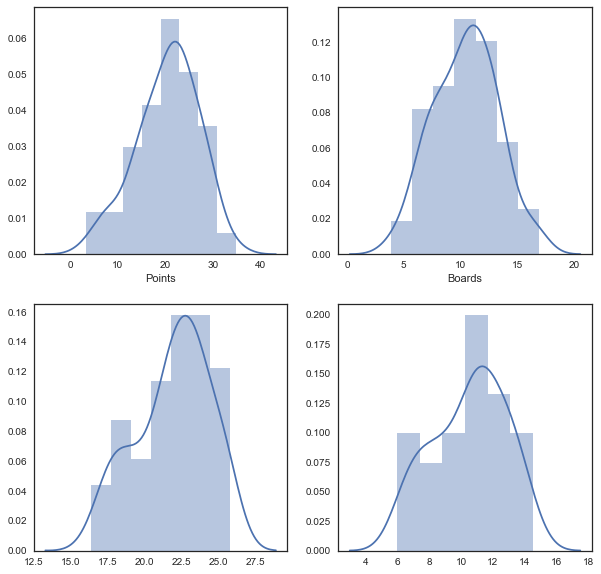

In [140]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
point_dist = sns.distplot(points[:85], label="Points",ax=ax1 )
boards_dist = sns.distplot(boards[:85], label="Boards", ax=ax2)
clean_points_plot = sns.distplot(cleanPoints[:85], label="cleanPoints",ax=ax3)
clean_boards_plot = sns.distplot(cleanBoards[:85], label="cleanBoards",ax=ax4)

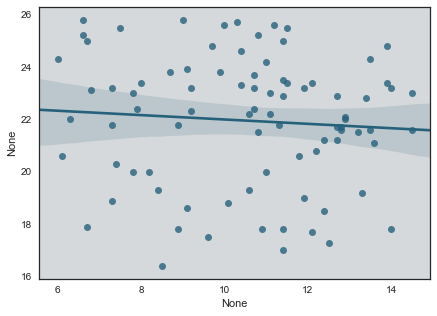

In [156]:
f, ax = plt.subplots(figsize = (7,5))

ax.set_facecolor('#d6d9db')
ax = sns.regplot(x=pd.Series(cleanBoards[:85]), 
                 y=pd.Series(cleanPoints[:85]),
                 color="#26617c")